# GENDER CLASSIFICATION

In [1]:
# Import required libraries.
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [2]:
BASIC_PATH = "/kaggle/input/celeba-dataset"
IMG_PATH = os.path.join(BASIC_PATH,'img_align_celeba/img_align_celeba')
FEATURE_PATH = os.path.join(BASIC_PATH,'list_attr_celeba.csv')

In [3]:
n_images = len(os.listdir(IMG_PATH))
print("Total Images in the Dataset: ", n_images)

Total Images in the Dataset:  202599


In [4]:
# Read the attributes csv files in a dataframe format.
df = pd.read_csv(FEATURE_PATH, usecols=['image_id','Male'])
df = df.sample(n=5000, random_state = 42).reset_index(drop=True)

# Reset the columns values to categorical./
df.loc[df['Male'] == -1,'Male'] = "Female"
df.loc[df['Male'] == 1,'Male'] = "Male"

# Change column names.
df.columns = ["image_id", "Gender"]

df.head(10)

,image_id,Gender
0,093242.jpg,Male
1,121414.jpg,Female
2,010625.jpg,Male
3,082524.jpg,Female
4,073193.jpg,Female
5,176200.jpg,Female
6,041602.jpg,Female
7,065466.jpg,Male
8,019028.jpg,Male
9,164498.jpg,Female


## Sample Images

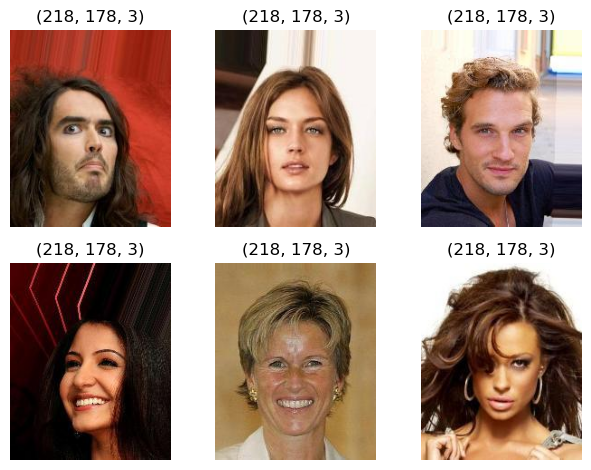

In [5]:
# Display Multiple Sample Images.
for i in range(0, 6):
    plt.subplot(2, 3, i+1)
    
    # Read an Image.
    img = cv2.imread(IMG_PATH + '/' + df["image_id"][i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display Image.
    plt.imshow(img)
    plt.title(img.shape)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In [6]:
# Get the category distribution.
category_count = df["Gender"].value_counts()
print(category_count)

higher_category = list(category_count.index)[0]

Female    2917
Male      2083
Name: Gender, dtype: int64


In [7]:
# Get the indices of the higher category indices images.
np.random.seed(42)
indices = df[df["Gender"] == higher_category].index
sample_size = category_count[0] - category_count[1]

# Drop the extra rows of female images to fix class imbalance problem.
drop_sample = np.random.choice(indices, sample_size, replace = False)
df = df.drop(drop_sample, axis = "index")



<AxesSubplot:>

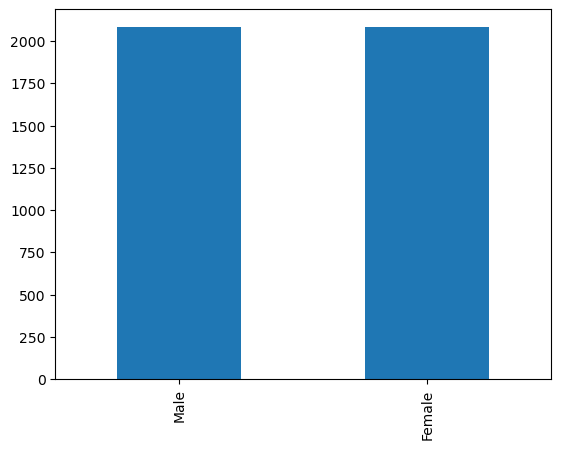

In [8]:
df["Gender"].value_counts().plot.bar()

## Train, Test, and Validation Split

In [9]:
train_df, test_df = train_test_split(df, test_size=0.3)
test_df, validation_df = train_test_split(test_df, test_size=0.38)

In [10]:
print("Total Train Sample Images : ", len(train_df))
print("Total Test Sample Images : ", len(test_df))
print("Total Validation Sample Images : ", len(validation_df))

Total Train Sample Images :  2916
Total Test Sample Images :  775
Total Validation Sample Images :  475


## Create Image Data Generators for train and validation data

In [11]:
IMAGE_SIZE = (218, 178)
BATCH_SIZE = 128

In [12]:
# Generate Train Images Data Generator.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    IMG_PATH + "/", 
    x_col='image_id',
    y_col='Gender',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 2916 validated image filenames belonging to 2 classes.


In [13]:
# Generate Validation Images Data Generator.
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df, 
    IMG_PATH + "/", 
    x_col='image_id',
    y_col='Gender',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 475 validated image filenames belonging to 2 classes.


In [14]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    IMG_PATH + "/",  
    x_col='image_id',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 775 validated image filenames.


# VGG-16:

In [17]:
base_vgg_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape= IMAGE_SIZE + (3,))

58889256/58889256 [==============================] - 3s 0us/step


In [18]:
base_vgg_model.trainable = False
base_vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 218, 178, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 218, 178, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 218, 178, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 109, 89, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 109, 89, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 109, 89, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 54, 44, 128)       0     

In [20]:
vgg_model = Sequential(
    [
    base_vgg_model,
    Flatten(),
    Dense(256,activation='relu'),
    Dense(256,activation='relu'),
    Dense(64,activation='relu'),
    Dense(64,activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='sigmoid')
]
)

In [21]:
vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 5, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 15360)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               3932416   
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 64)                16448     
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 32)               

In [29]:
vgg_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.001)
callbacks = [earlystop, learning_rate_reduction]

In [32]:
history = vgg_model.fit(train_generator, validation_data = validation_generator
                        , validation_steps=len(validation_df)//BATCH_SIZE
                        ,steps_per_epoch=len(train_df)//BATCH_SIZE,
                        epochs=13, verbose = 1, callbacks=callbacks)

Epoch 1/13
22/22 [==============================] - 49s 2s/step - loss: 0.4899 - accuracy: 0.7482 - val_loss: 0.2778 - val_accuracy: 0.8854 - lr: 0.0010
Epoch 2/13
22/22 [==============================] - 33s 1s/step - loss: 0.2988 - accuracy: 0.8759 - val_loss: 0.2584 - val_accuracy: 0.9036 - lr: 0.0010
Epoch 3/13
22/22 [==============================] - 33s 1s/step - loss: 0.2522 - accuracy: 0.9049 - val_loss: 0.2281 - val_accuracy: 0.9193 - lr: 0.0010
Epoch 4/13
22/22 [==============================] - 32s 1s/step - loss: 0.2342 - accuracy: 0.9085 - val_loss: 0.2911 - val_accuracy: 0.9036 - lr: 0.0010
Epoch 5/13
22/22 [==============================] - 32s 1s/step - loss: 0.2187 - accuracy: 0.9154 - val_loss: 0.2567 - val_accuracy: 0.9089 - lr: 0.0010
Epoch 6/13
22/22 [==============================] - 34s 2s/step - loss: 0.1876 - accuracy: 0.9286 - val_loss: 0.2076 - val_accuracy: 0.9297 - lr: 0.0010
Epoch 7/13
22/22 [==============================] - 33s 1s/step - loss: 0.1797 - a

# Saving The Model

In [33]:
vgg_model.save("model.h5")

# Loading the Model

In [34]:
vgg_model = tf.keras.models.load_model("/kaggle/working/model.h5")

In [35]:
vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 5, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 15360)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               3932416   
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 64)                16448     
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 32)               

# Prediction & Testing the model

In [46]:
def visualize_training(history, lw = 3):
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot(history.history['acc'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_acc'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend(fontsize = 'x-large')

    plt.subplot(2,1,2)
    plt.plot(history.history['loss'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_loss'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize = 'x-large')
    plt.grid(True)
    plt.show()


visualize_training(hist)

In [36]:
vgg_model.evaluate(test_generator)

7/7 [==============================] - 5s 697ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]

In [37]:
predict = vgg_model.predict(test_generator, steps=np.ceil(len(test_df)/BATCH_SIZE))

7/7 [==============================] - 4s 517ms/step


In [38]:
prediction = predict.argmax(axis=-1)
test_df['Prediction'] = ["Male" if ele == 1 else "Female" for ele in prediction]

In [39]:
test_df

,image_id,Gender,Prediction
1805,152742.jpg,Female,Female
785,008480.jpg,Male,Male
4147,084644.jpg,Male,Female
2730,057803.jpg,Female,Female
3438,035491.jpg,Male,Male
...,...,...,...
2793,094830.jpg,Female,Female
1120,135246.jpg,Male,Male
244,088410.jpg,Male,Male
3159,027952.jpg,Female,Male


In [40]:
labels = ['Male','Female']

cm = confusion_matrix(test_df['Gender'], test_df["Prediction"], labels= labels)
cm

array([[359,  39],
       [ 27, 350]])

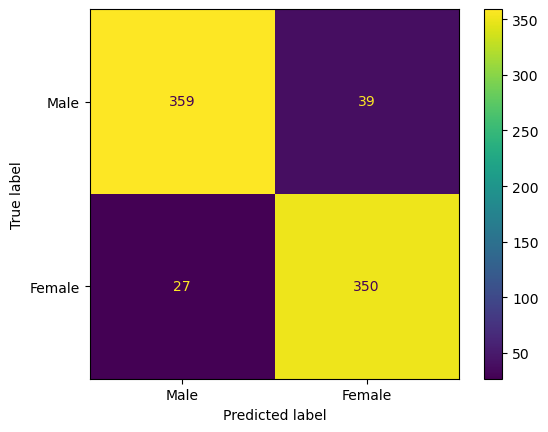

In [41]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

Above 90% Accuracy is obtained. WoW!!